In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from compare_tools.hathimeta import HathiMeta, get_json_meta
from compare_tools.configuration import config, init_htid_args
from compare_tools.comparison import Comparison, HTIDComparison
from compare_tools.utils import HTID
htid_args = init_htid_args(config)

In [3]:
config

{'rsync_root': '/drobo/feature-counts',
 'meta_path': '/drobo/hathi-test-dataset/test_dataset.csv.gz',
 'metadb_path': '/drobo/hathi-test-dataset/test_dataset.sqlite',
 'scratch': '/drobo/scratch/',
 'parquet_root': '/drobo/hathi-parquet',
 'parquet_chunked_root': '/drobo/hathi-parquet-chunked',
 'SRP_data_path': '/drobo/vector_sets/SRP_vectors.bin',
 'glove_data_path': '/drobo/vector_sets/glove_vectors.bin',
 'resolver': [{'dir': '/home/bschmidt/hathi-parquet',
   'format': 'parquet',
   'compression': 'gzip',
   'index': False,
   'indexed': False,
   'cache': True,
   'token_kwargs': {'pos': False, 'section': 'body', 'drop_section': True}},
  {'dir': '/home/bschmidt/hathi-ef',
   'format': 'json',
   'compression': 'bz2',
   'id_resolver': 'pairtree'}],
 'glove_location': '/drobo/hathi-test-dataset/glove.bin'}

In [4]:
import pandas as pd
sample_data = pd.read_csv("http://35.239.220.133/download")

In [7]:
import random
k = random.randint(0, sample_data.shape[0])
g = sample_data.iloc[k]
ids =  [g['target'].replace("=", "/"),g['candidate'].replace("=", "/")] 
print(g)

Unnamed: 0                            8
rater                              Rita
target        coo1.ark:/13960=t10p1mg7f
candidate      aeu.ark:/13960/t1xd1kr96
judgment                         AUTHOR
notes                               NaN
timestamp                   1.58128e+09
Name: 1760, dtype: object


In [9]:
sample_data.groupby("judgment").count()

,Unnamed: 0,rater,target,candidate,notes,timestamp
judgment,,,,,,
AUTHOR,1443,1443,1443,1443,16,1443
CONTAINS,13,13,13,13,4,13
DIFF,70,70,70,70,2,70
Other,9,9,9,9,9,9
PARTOF,26,26,26,26,1,26
SWDE,241,241,241,241,32,241
SWSM,316,316,316,316,21,316
TO_DISCUSS,8,8,8,8,8,8
UNKNOWN,4,4,4,4,1,4


This notebooks demonstrates page-level Jaccard similarity. This an expensive procedure, but useful as a ground truth.

The algorithms for extracting runs operate on the Jaccard similarity matrix for pages the same way they do on GloVe or SRP
matrices for chunked books.

In [16]:
some_comps = sample_data[sample_data.judgment.str.match("SWDE|SWSM")].sample(250)

In [17]:
assessment = some_comps.iloc[3]
judgment = assessment.judgment
comp = HTIDComparison(ids = [assessment.target, assessment.candidate], **htid_args)
stats = comp.jaccard_stats('page')

/home/bschmidt/miniconda3/envs/htrc/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [18]:
import warnings
import sys

Some test code to explore vol and page methods. Can be cut.

In [ ]:
comparisons = []
for i, (x, assessment) in enumerate(some_comps.iterrows()):
    judgment = assessment.judgment
    comp = HTIDComparison(ids = [assessment.target, assessment.candidate], **htid_args)
    with warnings.catch_warnings():
        # God help me, I can't find the block of code emitting a pd.errors.PerformanceWarning here.
        warnings.simplefilter("ignore")
        try:
            stats = comp.jaccard_stats('page')  
        except KeyError:
            print(f"\nError on {assessment.target} to {assessment.candidate} comparison--deficient data?")
    stats['judgment'] = judgment
    stats['left'] = assessment.target
    stats['right'] = assessment.candidate
    comparisons.append(stats)
    sys.stdout.write(f"{i},")


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,
Error on hvd.hc4btz to hvd.32044097028526 comparison--deficient data?
27,

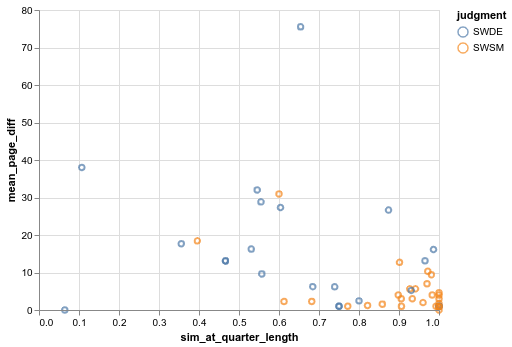

In [145]:
comp_data = pd.DataFrame(comparisons)

alt.Chart(comp_data).mark_point().encode(x = "sim_at_quarter_length", y = "mean_page_diff", color="judgment")

In [183]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive

X = comp_data.drop(["left", "right", "judgment", "weighted_in_run_word_slope"], axis = 1)#.values

In [184]:
dtree=DecisionTreeClassifier()
dtree.fit(X, comp_data.judgment)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [190]:
labels = X.columns

def plot_tree(crit, split, depth, min_split, min_leaf=0.2):
    estimator = DecisionTreeClassifier(random_state = 0 
          , criterion = crit
          , splitter = split
          , max_depth = depth
          , min_samples_split=min_split
          , min_samples_leaf=min_leaf)
    estimator.fit(X, comp_data.judgment)
    graph = Source(tree.export_graphviz(estimator
          , out_file=None
          , feature_names=labels
          , class_names=['0', '1', '2']
          , filled = True))

    display(SVG(graph.pipe(format='svg')))
    return estimator

inter=interactive(plot_tree 
   , crit = ["gini", "entropy"]
   , split = ["best", "random"]
   , depth=[1,2,3,4]
   , min_split=(0.1,1)
   , min_leaf=(0.1,0.5))
display(inter)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [62]:
scope = "page"

I find 0.2 to be a reasonable threshold for Jaccard similarity. As you see here, there are many page-comparison pairs that reach 0.2 similarity (maybe largely short pages?) but the main run of similarity is successfully extracted.

Here are some statistics about this comparison.A brief explanation:

* mean_page_diff looks at runs and pulls the average page difference in absolute numbers. If this is zero, it's a strong sign of SWSM; if this is very high, it's a strong sign of enclosure or some other relationship where runs are offset by tens or hundreds of pages.
* sd_page_diff is how much the page difference within runs varies. Again, low values indicate SWSM.
* mean_similarity_inside_of_runs is Jaccard sim in runs.
* mean_similarity_to_right_of_runs is Jaccard sim immediately to the right of runs in the adjacency matrix. If there are high, it indicates some closeness.
* share_l_in_r and share_r_in_l give some enclosure stats for finding enclosure.
* overall_slope gives the slope of a linear model fitted to all run pairs.
* weighted_in_run_page_slope is the average slope of the pagewise matches. if this is one, it indicates that the runs are always up and to the left.
* weighted_in_run_word_slope is the slope adjusting for word lengths. This is a funny proxy to catch if the word counts are different between the books.
* sim_at_{X}_length captures the similarity score for the weighted matrix at four points relative to the shorter of the two books. See below

In [63]:
comp.jaccard_stats(scope)

/home/bschmidt/miniconda3/envs/htrc/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


{'mean_page_diff': 0.0,
 'sd_page_diff': 0.0,
 'mean_similarity_inside_runs': 0.8206980915964219,
 'mean_similarity_to_right_of_runs': 0.0652208670184062,
 'share_l_in_r': 0.910958904109589,
 'share_r_in_l': 0.9300699300699301,
 'overall_slope': 1.0000000000000002,
 'strength_of_overall_fit': 1.0,
 'weighted_in_run_page_slope': 1.0,
 'weighted_in_run_word_slope': 1.0010960188519586,
 'sim_at_quarter_length': 0.95,
 'sim_at_half_length': 0.8928571428571429,
 'sim_at_full_length': 0.21153846153846154,
 'sim_at_double_length': 0.1111111111111111}

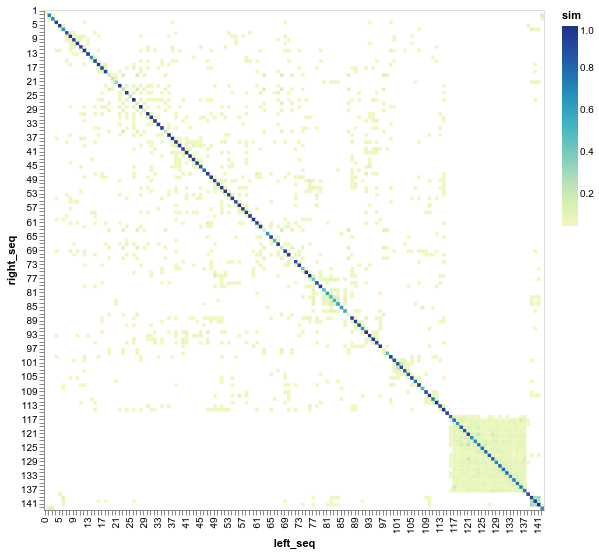

In [64]:
# This will only work if `jaccard_stats` is run before, because it needs the runs in place.
comp.plot("jaccard_matrix", scope=scope, filter = lambda x: x >= 0.05, runs = False).properties(width=500, height=500)


The fraction capture the charts we were making earlier of ordered similarity.

I would like to figure out how to parameterize these, but instead just pick the points at .25, .5, 1, and 2 in the chart below or their equivalent. I'm not sure those are the best choices.

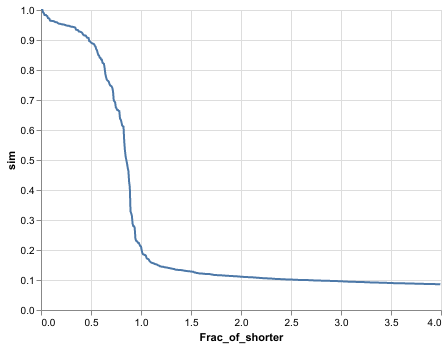

In [66]:
import altair as alt
import numpy as np
flat = comp.four_points(raw_data = True)

alt.Chart(pd.DataFrame({'sim': flat, 'Frac_of_shorter':np.arange(len(flat))/(len(flat)/ 4)})).mark_line().encode(y='sim', x = 'Frac_of_shorter')
